# 1. Import Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
)

# 2. Membaca File CSV

In [2]:
import pandas as pd
df = pd.read_csv("../data/stunting_wasting_dataset.csv")
df.head()

,Jenis Kelamin,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting,Wasting
0,Laki-laki,19,91.6,13.3,Tall,Risk of Overweight
1,Laki-laki,20,77.7,8.5,Stunted,Underweight
2,Laki-laki,10,79.0,10.3,Normal,Risk of Overweight
3,Perempuan,2,50.3,8.3,Severely Stunted,Risk of Overweight
4,Perempuan,5,56.4,10.9,Severely Stunted,Risk of Overweight


# 3. Melihat info umum dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Jenis Kelamin      100000 non-null  object 
 1   Umur (bulan)       100000 non-null  int64  
 2   Tinggi Badan (cm)  100000 non-null  float64
 3   Berat Badan (kg)   100000 non-null  float64
 4   Stunting           100000 non-null  object 
 5   Wasting            100000 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB


# 4. Data Pre-processing

4.1 Cek Missing Value

In [4]:
df.isnull().sum()

Jenis Kelamin        0
Umur (bulan)         0
Tinggi Badan (cm)    0
Berat Badan (kg)     0
Stunting             0
Wasting              0
dtype: int64

4.2 Cek Nilai Unik

In [6]:
df['Stunting'].unique()


array(['Tall', 'Stunted', 'Normal', 'Severely Stunted'], dtype=object)

In [7]:
df['Jenis Kelamin'].unique()

array(['Laki-laki', 'Perempuan'], dtype=object)

4.3 Mapping Kolom Kategorik ke Bentuk Numerik

In [13]:
# 1. maping kolom Stunting menjadi biner
map_stunt = {'Stunted' : 1, 'Severaly Stunted' : 1, 'Normal' : 0, 'Tall' : 0}
df ['Stunting_bin'] = df['Stunting'].map(map_stunt).astype('Int64')

# 2. maping kolom Jenis Kelamin menjadi biner
# 'Laki-laki' : 1, 'Perempuan' : 0
df ['JK_bin'] = (df['Jenis Kelamin'] == 'Laki-laki').astype(int)

print("Distribusi Stunting_bin:\n", df['Stunting_bin'].value_counts())
print("\nDistribusi JK_bin:\n", df['JK_bin'].value_counts())

Distribusi Stunting_bin:
 Stunting_bin
0    78021
1    16160
Name: count, dtype: Int64

Distribusi JK_bin:
 JK_bin
1    50179
0    49821
Name: count, dtype: int64


4.4 Analisis Korelasi Antar Variabel Numerik 


In [14]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),Stunting_bin,JK_bin
Umur (bulan),1.000000,0.875869,0.665389,0.061955,0.004046
Tinggi Badan (cm),0.875869,1.000000,0.626005,-0.224156,0.073505
Berat Badan (kg),0.665389,0.626005,1.000000,0.037797,0.045797
Stunting_bin,0.061955,-0.224156,0.037797,1.000000,-0.009779
JK_bin,0.004046,0.073505,0.045797,-0.009779,1.000000


4.5 Visualisasi Heatmap Korelasi

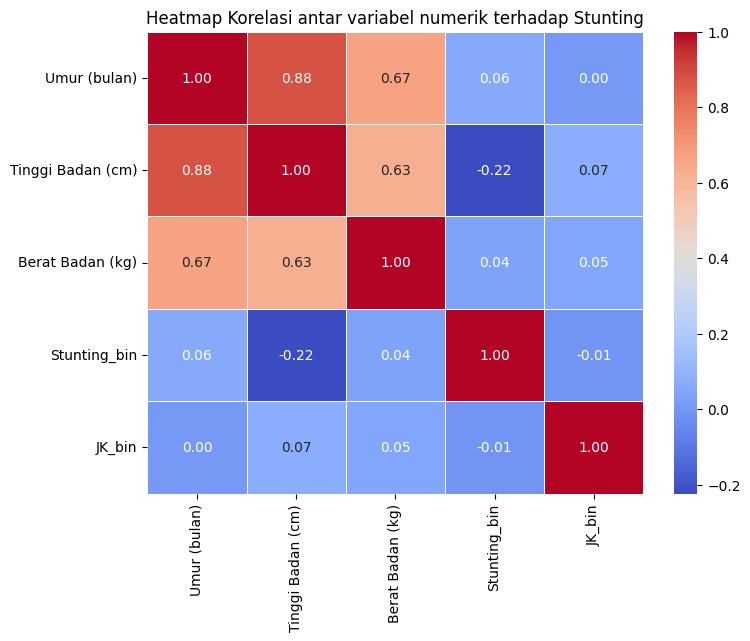

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f" , linewidths=0.5) 
plt.title("Heatmap Korelasi antar variabel numerik terhadap Stunting")
plt.show()

# 5. Pembagian Dataset (Training dan Testing)


5.1 Menentukan Fitur dan Target


In [17]:
# fitur numerik dan gender
feature_num = ['Umur (bulan)', 'Tinggi Badan (cm)', 'Berat Badan (kg)']
feature_bin = ['JK_bin']

# gabungkan & drop missing
use_cols = feature_num + feature_bin + ['Stunting_bin']
df_model = df[use_cols].dropna().copy()

X = df_model[feature_num + feature_bin]
y = df_model['Stunting_bin']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (94181, 4)
y shape: (94181,)


5.2 Membagi Dataset menjadi Training dan Testing Set


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("data latih:", X_train.shape, y_train.shape)
print("data uji:", X_test.shape, y_test.shape)

data latih: (75344, 4) (75344,)
data uji: (18837, 4) (18837,)


# 6. Pembangunan Model Logistic Regression

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# scale hanya fitur numerik, gender langsung passthrough
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), feature_num),
        ('bin', 'passthrough', feature_bin)
    ])

model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# latih model
clf.fit(X_train, y_train)
print("Model berhasil dilatih.")

Model berhasil dilatih.


# 7. Prediksi Model dan Evaluasi Model


In [42]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# prediksi & probabilitas
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# hitung numerik
print(f"Akurasi: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

Akurasi: 0.8943
Precision: 0.6252
Recall: 0.9579
F1-score: 0.7566
ROC AUC: 0.9599


# 8. Visualisasi Hasil Evaluasi


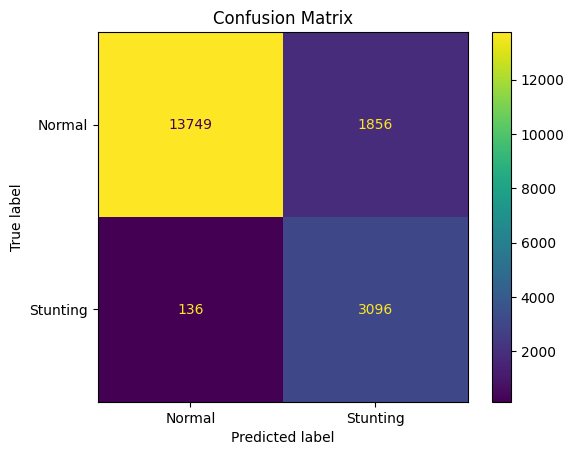

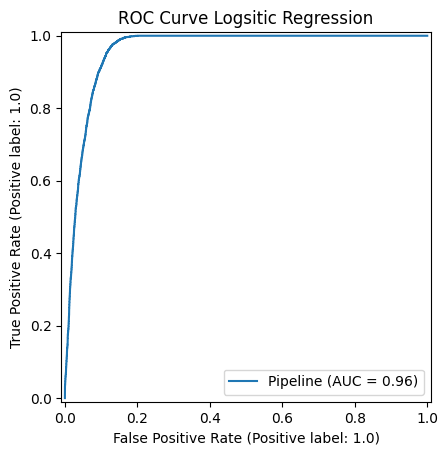

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=['Normal', 'Stunting']).plot(values_format='d')
plt.title("Confusion Matrix")
plt.show()

#ROC curve
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title("ROC Curve Logsitic Regression")
plt.show()
                       

# 9. Classification Report


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=['Tidak Stunting (0)', 'Stunting (1)']))

                    precision    recall  f1-score   support

Tidak Stunting (0)       0.99      0.88      0.93     15605
      Stunting (1)       0.63      0.96      0.76      3232

          accuracy                           0.89     18837
         macro avg       0.81      0.92      0.84     18837
      weighted avg       0.93      0.89      0.90     18837



# 10. Classification Report


In [36]:
import numpy as np
from sklearn.model_selection import cross_val_score

#lakukan cross-validation (cv=5 berarti 5 fold)
scores = cross_val_score(clf, X, y, cv=5)

# Tampilkan hasil cross-validation
print("Skor tiap fold:", scores)
print("Rata-rata skor:", np.mean(scores))
print("standar deviasi:", np.std(scores))

Skor tiap fold: [0.89531242 0.88978552 0.89360798 0.88718412 0.88898917]
Rata-rata skor: 0.8909758408110315
standar deviasi: 0.0030157913854655903


# 11. Interpretasi Model Logistic Regression


In [38]:
# Ambil nama fitur dan koefisien
feat_nama = feature_num + feature_bin
coef = clf.named_steps['model'].coef_[0]
odds  = np.exp(coef)

coef_df = pd.DataFrame({
    'Fitur': feat_nama,
    'Koefisien': coef,
    'Odds Ratio': odds
}).sort_values('Odds Ratio', ascending=False)

display(coef_df)

,Fitur,Koefisien,Odds Ratio
0,Umur (bulan),8.310390,4065.897805
3,JK_bin,1.627485,5.091057
2,Berat Badan (kg),0.629313,1.876321
1,Tinggi Badan (cm),-10.161155,0.000039


# 12. Prediksi Data Baru (Contoh Kasus)


In [40]:
# contoh data 2 anak
data_baru = pd.DataFrame({
    'Umur (bulan)': [24, 10],
    'Tinggi Badan (cm)': [79.0, 72.5],
    'Berat Badan (kg)': [9.2, 7.8],
    'JK_bin': [1, 0]  # 1: Laki-laki, 0: Perempuan
})

pred = clf.predict(data_baru)
prob = clf.predict_proba(data_baru)[:, 1]

hasil = data_baru.copy()
hasil['Prob_stunting'] = prob
hasil['Pred (0=tidak,1=ya)'] = pred
display(hasil)

,Umur (bulan),Tinggi Badan (cm),Berat Badan (kg),JK_bin,Prob_stunting,"Pred (0=tidak,1=ya)"
0,24,79.0,9.2,1,0.998298,1.0
1,10,72.5,7.8,0,0.003024,0.0
